In [21]:
import pandas as pd
import numpy  as np
from pathlib import Path
print("Libraries loaded")

Libraries loaded


# Step 2 load raw csv files

In [22]:
root = Path("/Users/benymean/Desktop/WYDA Data/Test Data")          # adjustable

users      = pd.read_csv(root/"Users.csv",
                         parse_dates=["created_at", "updated_at"])
attempts   = pd.read_csv(root/"ScenariosAttempts.csv",
                         parse_dates=["created_at", "finished_at"])
responses  = pd.read_csv(root/"ScenariosResponses.csv")
reflect    = pd.read_csv(root/"ReflectionsResponses.csv")

print(users.shape, attempts.shape, responses.shape, reflect.shape)
assert users.shape[0] > 0, "Users table empty"


(47, 9) (1153, 17) (23924, 23) (3224, 15)


# Step 3 Cleaning column names

All four tables share learner IDs but name them differently (id, user_id). Renaming removes ambiguity so merges are one-liner joins rather than fiddly look-ups.

Remove noise. PartitionKey and RowKey come from Azure Table Storage are useful only for the original back-end not for analytics. Keeping them risks accidentally treating them as categorical features.

Future-proofing. Clean, snake-case names are easier to call in functions and avoid clashes with reserved words.

In [23]:
# Dropping Azure storage keys we won’t model on
for df in (users, attempts, responses, reflect):
    df.drop(columns=[c for c in df.columns if c in ("PartitionKey",
                                                    "RowKey")],
            inplace=True, errors="ignore")

# Giving consistent id names
attempts.rename (columns={"id":"attempt_id"},  inplace=True)
responses.rename(columns={"id":"response_id"}, inplace=True)
reflect.rename  (columns={"id":"reflection_id"}, inplace=True)


In [24]:
expected = {"attempt_id", "user_id", "scenario_id"}
assert expected.issubset(attempts.columns)

# Step 4 basic data health check
If a column shows > 60 % missing, we decide whether to drop or impute it.

In [25]:
def miss_report(df, name):
    pct = (df.isna().mean()*100).sort_values(ascending=False)[:5]
    print(f"{name}: top NA %\n{pct}\n")

miss_report(users,      "users")
miss_report(attempts,   "attempts")
miss_report(responses,  "responses")
miss_report(reflect,    "reflect")


users: top NA %
id            0.0
email         0.0
region        0.0
created_at    0.0
createdAt     0.0
dtype: float64

attempts: top NA %
wellbeing             64.874241
correct_percentage    59.410234
points                55.680833
attempt_id             0.000000
user_id                0.000000
dtype: float64

responses: top NA %
question_response_4    99.995820
question_response_3    99.736666
question_response_2    99.565290
question_response_1    99.097141
option_id              15.871092
dtype: float64

reflect: top NA %
response         41.563275
reflection_id     0.000000
user_id           0.000000
program_id        0.000000
level_id          0.000000
dtype: float64



| Table | Column(s) > 60 % NA | Interpretation | Suggested action |
|-------|---------------------|----------------|------------------|
| **attempts** | `wellbeing` (65 %), `correct_percentage` (59 %), `points` (56 %) | Only ~⅓ of attempts store these metrics.  They’re useful but far from universal. | *Modelling:* keep them as features **and** add companion flags (`is_wellbeing_missing`, etc.) so tree models can learn “missingness=signal.”  For simple models, imputing with sentinel values (e.g., –1). |
| **responses** | `question_response_1–4` (~99 %) | Each scenario uses only one of the four slots, so almost every row has three blanks by design. | Pivot or melt to a single “response_text” column when you process questions; ignore the others. |
|  | `option_id` (16 %) | Null means the question wasn’t multiple-choice. | Safe to keep; missingness itself tells you question type. |
| **reflect** | `response` (42 %) | 58 % of reflection rows contain text; 42 % are blank (skipped). | captured via `txt_completion_rate` |
| **users** | *No missing values* | Good — demographic keys are intact. | — |

# Step 5 features engineering

Goal: collapse event-level logs into learner-level metrics that our model (and coaches) can easily digest.


## 5.1 Prepare attempts for time-series ops
- We guarantee chronological order inside each learner.
- Cast possible text fields to numeric so aggregations work.




## 5.2 `feat_attempts` – core performance & pace

- assign(prev_time=…) adds the lagged timestamp.

- Gaps for a learner’s first record stay NaN; .mean() auto-ignores.

## 5.3 `feat_responses` – answer volume
- Counts every question row across all scenarios.


## 5.4 `feat_reflect` – reflection depth

- `n_reflections` – how often they engage with reflection prompts.

- `txt_completion_rate` – proportion of reflections that contain non-empty text.

- Low completion often signals disengagement.


## 5.5 Struggle flag – “retries without pass”
- Learner kept retrying a scenario > 1 × but never passed → early frustration signal.

## 5.6 Quick-win behavioural features (12 metrics)
| Category | Feature | Formula |
|----------|---------|---------|
| **Performance & volume** | `pass_rate` | `n_passed / n_attempts` |
|  | `retry_rate` | share of scenarios with >1 attempt |
|  | `recent_7d_attempts` | attempts in last 7 days |
| **Cadence** | `distinct_days_active` | unique active dates |
|  | `longest_activity_streak` | max consecutive-day run |
| **Points & effort** | `avg_points`, `points_std` | mean / std of `points` |
|  | `total_minutes_spent` | Σ `duration`|
| **Well-being & reflection** | `wellbeing_mean` | mean self-reported score |
|  | `avg_reflection_len` | mean char length of reflection text |



In [26]:
# sort to make time series ops easier
attempts.sort_values(["user_id", "finished_at"], inplace=True)

feat_attempts = (
    attempts
      .assign(prev_time = attempts.groupby("user_id")["finished_at"].shift())
      .pipe(lambda df: pd.DataFrame({
          "n_attempts"     : df.groupby("user_id").size(),
          "n_passed"       : (df["state"]=="passed").groupby(df["user_id"]).sum(),
          "mean_gap_hours" : (df["finished_at"]-df["prev_time"]
                              ).dt.total_seconds().groupby(df["user_id"]
                              ).mean()/3600
      }))
)

feat_responses = responses.groupby("user_id").size().rename("n_question_rows")
feat_reflect   = reflect.groupby("user_id").agg(
                     n_reflections       = ("reflection_id","count"),
                     txt_completion_rate = ("response",
                                            lambda s: (s.notna() & (s.str.len()>0)
                                                       ).mean())
                 )


In [27]:
# Quick Test
print(feat_attempts.head())
assert feat_attempts.index.is_unique


                                      n_attempts  n_passed  mean_gap_hours
user_id                                                                   
008edba3-77e9-4b9b-a047-da5a1b98fd75           1         1             NaN
04050ff3-37d3-4f18-abc6-0d7203d0106f          40        17       33.202707
095af668-642a-40d2-abed-6fe199220ce0          28        12       39.509918
0c78fdf3-85c4-4afe-85b2-851fe32a2a54          41        17       34.010438
1c6f6075-03db-4876-bf5c-7c4dddfef825          16         8       54.665685


In [28]:
tmp = (
    attempts
      .groupby(["user_id", "scenario_id"])
      .agg(
          n_attempts=("attempt_id", "count"),
          any_pass  =("state",      lambda s: (s == "passed").any())
      )
)

retries_no_pass = (
    tmp.query("n_attempts > 1 and any_pass == False")
       .groupby(level=0)
       .size()
       .rename("n_retries_no_pass")
) 


In [29]:
# ╔══════════════════════════════════════════════════════════════════╗
# ║         QUICK-WIN BEHAVIOURAL FEATURES (12 columns)
# ╚══════════════════════════════════════════════════════════════════╝

from functools import reduce

# ── ensure numeric columns are really numeric ────────────────────────────
for col in ["points", "duration", "wellbeing"]:
    attempts[col] = pd.to_numeric(attempts[col], errors="coerce")


today = attempts["finished_at"].max()  # snapshot 'now'

# --- 1 pass_rate -------------------------------------------------------------
pass_rate = (feat_attempts["n_passed"] / feat_attempts["n_attempts"]).fillna(0)

# --- 2 recent_7d_attempts ----------------------------------------------------
recent_7d = (
    attempts[attempts.finished_at >= today - pd.Timedelta(days=7)]
      .groupby("user_id").size()
)

# --- 3 distinct_days_active --------------------------------------------------
days_active = (
    attempts.groupby('user_id')['finished_at']
            .apply(lambda s: s.dt.date.nunique())
)

# --- 4 longest_activity_streak ----------------------------------------------
def longest_streak(dates):
    if len(dates) == 0:
        return 0
    d = pd.Series(sorted(dates)).diff().ne(pd.Timedelta(days=1)).cumsum()
    return d.value_counts().max()

streak = (
    attempts.assign(day=attempts.finished_at.dt.date)
            .drop_duplicates(["user_id","day"])
            .groupby("user_id")["day"]
            .apply(longest_streak)
)

# --- 6 & 7 points mean / std -------------------------------------------------
avg_pts = attempts.groupby("user_id")["points"].mean()
std_pts = attempts.groupby("user_id")["points"].std()

# --- 8 total_minutes_spent ---------------------------------------------------
total_min = attempts["duration"].groupby(attempts["user_id"]).sum() / 60

# --- 9 wellbeing_mean --------------------------------------------------------
wb_mean = attempts.groupby("user_id")["wellbeing"].mean()

# ---10 avg_reflection_len ----------------------------------------------------
ref_len = (reflect.groupby("user_id")["response"]
                   .apply(lambda s: s.dropna().str.len().mean()))

# ---11 retry_rate ------------------------------------------------------------
retry_rate = (
    attempts.groupby(["user_id","scenario_id"]).size().gt(1)
            .groupby(level=0).mean()
)

# ---12 avg_attempts_to_first_pass -------------------------------------------
def attempts_to_first_pass(g):
    first_pass_idx = g[g["state"]=="passed"].index.min()
    return g.loc[:first_pass_idx].shape[0] if pd.notna(first_pass_idx) else np.nan

first_pass = (
    attempts.sort_values("finished_at")
            .groupby(["user_id","scenario_id"])
            .apply(attempts_to_first_pass)
)

first_pass_avg = first_pass.groupby("user_id").mean()

# ---------------------------------------------------------------------------
# COLLECT EVERYTHING INTO ONE DATAFRAME
quick_feats = {
    "pass_rate"             : pass_rate,
    "recent_7d_attempts"    : recent_7d,
    "distinct_days_active"  : days_active,
    "longest_activity_streak": streak,
    "avg_points"            : avg_pts,
    "points_std"            : std_pts,
    "total_minutes_spent"   : total_min,
    "wellbeing_mean"        : wb_mean,
    "avg_reflection_len"    : ref_len,
    "retry_rate"            : retry_rate,
    "avg_attempts_to_pass"  : first_pass_avg,
}

# --- turn the dict of Series into a learner-level DataFrame --------------
for name, s in quick_feats.items():
    s.name = name

quick_feats_df = (
    pd.concat(quick_feats.values(), axis=1)   # align on user_id
      .fillna(0)
)
quick_feats_df.index.name = "user_id"        # keep index for merging


In [30]:
# ── diagnostics -----------------------------------------------------------
print("Core feats :", feat_attempts.shape,
      feat_responses.shape, feat_reflect.shape)
print("Struggle   :", retries_no_pass.shape)
print("Quick-win  :", quick_feats_df.shape)

assert feat_attempts.index.is_unique, "duplicate user_ids in feat_attempts"
assert quick_feats_df.index.is_unique, "duplicate user_ids in quick_feats"


Core feats : (42, 3) (42,) (32, 2)
Struggle   : (0,)
Quick-win  : (42, 11)


# Step 6 merge feature tables
Combine everything into one learner-level frame; fill missing with 0.

In [31]:
features = (
    users.rename(columns={"id":"user_id"})
         .merge(feat_attempts,   left_on="user_id", right_index=True, how="left")
         .merge(feat_responses,  left_on="user_id", right_index=True, how="left")
         .merge(feat_reflect,    left_on="user_id", right_index=True, how="left")
         .merge(retries_no_pass, left_on="user_id", right_index=True, how="left")
         .merge(quick_feats_df,  left_on="user_id", right_index=True, how="left")  # ← use *_df
).fillna(0)


In [32]:
# Quick test
assert features.shape[0] == users.shape[0], "Row mismatch after merge"


# Step 7 create the target fall-behind flag

## Why we need it
A supervised model requires a known Y.
We define “falling behind” as no recorded scenario activity for seven consecutive days.
That is:

last_finished_attempt + 7 days  <  today   →  fall_behind = 1
otherwise                               →  fall_behind = 0



In [33]:
# How many distinct scenarios exist in the dataset?
total_scenarios = attempts["scenario_id"].nunique()
print("Total scenarios in this module:", total_scenarios)

# For each learner, count distinct scenarios they have PASSED
passed_scenarios = (
    attempts[attempts["state"] == "passed"]
        .groupby("user_id")["scenario_id"]
        .nunique()
        .rename("n_scenarios_passed")
)

# Merge that back to the features frame
features = features.merge(passed_scenarios, on="user_id", how="left")
features["n_scenarios_passed"].fillna(0, inplace=True)

# Mark completion
features["module_complete"] = (
    features["n_scenarios_passed"] >= total_scenarios
).astype(int)

print(features[["user_id", "n_scenarios_passed", "module_complete"]].head())


Total scenarios in this module: 17
                                user_id  n_scenarios_passed  module_complete
0  008edba3-77e9-4b9b-a047-da5a1b98fd75                 1.0                0
1  04050ff3-37d3-4f18-abc6-0d7203d0106f                17.0                1
2  095af668-642a-40d2-abed-6fe199220ce0                12.0                0
3  0c78fdf3-85c4-4afe-85b2-851fe32a2a54                17.0                1
4  0feb4760-6f29-4532-ab2d-ca114fd4f0c7                 0.0                0


In [34]:
# Quick test
assert features["module_complete"].isin([0,1]).all(), "Non-binary flag"

In [35]:
# keep previous days_since_last logic:
last_act = attempts.groupby("user_id")["finished_at"].max()
cutoff   = last_act + pd.Timedelta(days=7)
today    = attempts["finished_at"].max()      # or datetime.now(timezone.utc)

features = features.merge(cutoff.rename("cutoff"), on="user_id", how="left")
features["days_since_last"] = (
        today - features["cutoff"] + pd.Timedelta(days=7)
    ).dt.days.fillna(np.inf)

# behind = inactive ≥7d AND NOT module_complete
features["fall_behind"] = (
    (features["days_since_last"] >= 7) &
    (features["module_complete"] == 0)
).astype(int)

print(features["fall_behind"].value_counts())


0    25
1    22
Name: fall_behind, dtype: int64


### Edge-case handling

Learners with zero attempts – last_act is NaN → days_since_last becomes ∞ → fall_behind = 1 (reasonable: never started).

Future data – if the log uses UTC but the snapshot time zone shifts, the latest finished_at still defines “today”, so the rule remains stable.

Chooses seven days now, but you can switch to 14 days or any heuristic by replacing pd.Timedelta(days=7).



In [36]:
# Quick test
print(features["fall_behind"].value_counts(dropna=False))
assert {"fall_behind"}.issubset(features.columns)

0    25
1    22
Name: fall_behind, dtype: int64


### Save the Data Frame

In [17]:
features.head()

,user_id,email,region,created_at,createdAt,updated_at,updatedAt,n_attempts,n_passed,mean_gap_hours,...,total_minutes_spent,wellbeing_mean,avg_reflection_len,retry_rate,avg_attempts_to_pass,n_scenarios_passed,module_complete,cutoff,days_since_last,fall_behind
0,008edba3-77e9-4b9b-a047-da5a1b98fd75,redacted@wydaemailexample.com,unknown,2025-04-14 20:57:25+00:00,2025-04-14T20:57:25Z,2025-04-14 20:57:25+00:00,2025-04-14T20:57:25Z,1.0,1.0,0.000000,...,11.916667,0.0,0.000000,0.000000,1.0,1.0,0,2024-04-23 08:34:49+00:00,256.0,1
1,04050ff3-37d3-4f18-abc6-0d7203d0106f,redacted@wydaemailexample.com,unknown,2025-04-14 20:02:47+00:00,2025-04-14T20:02:47Z,2025-04-14 20:02:47+00:00,2025-04-14T20:02:47Z,40.0,17.0,33.202707,...,557.866667,0.0,83.415385,0.823529,1.0,17.0,1,2024-10-22 16:08:39+00:00,73.0,0
2,095af668-642a-40d2-abed-6fe199220ce0,redacted@wydaemailexample.com,unknown,2025-04-14 20:04:15+00:00,2025-04-14T20:04:15Z,2025-04-14 20:04:15+00:00,2025-04-14T20:04:15Z,28.0,12.0,39.509918,...,441.133333,0.0,109.420000,0.916667,1.0,12.0,0,2024-10-09 00:41:30+00:00,87.0,1
3,0c78fdf3-85c4-4afe-85b2-851fe32a2a54,redacted@wydaemailexample.com,unknown,2025-04-14 20:04:48+00:00,2025-04-14T20:04:48Z,2025-04-14 20:04:48+00:00,2025-04-14T20:04:48Z,41.0,17.0,34.010438,...,2402.116667,0.0,44.885714,0.882353,1.0,17.0,1,2024-10-21 11:54:31+00:00,75.0,0
4,0feb4760-6f29-4532-ab2d-ca114fd4f0c7,redacted@wydaemailexample.com,unknown,2025-04-14 20:17:56+00:00,2025-04-14T20:17:56Z,2025-04-14 20:17:56+00:00,2025-04-14T20:17:56Z,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,NaT,inf,1


| Feature | Meaning / Formula |
|----------|------------------|
| **n_attempts** | Total scenario launches per learner → `attempts.groupby("user_id").size()` |
| **n_passed** | Count of attempts with `state == "passed"` → `(attempts["state"]=="passed").groupby(attempts["user_id"]).sum()` |
| **mean_gap_hours** | Mean time gap between consecutive attempts → `((finished_at - prev_time).dt.total_seconds().groupby(user_id).mean()) / 3600` |
| **n_question_rows** | Number of rows answered in *ScenariosResponses* → `responses.groupby("user_id").size()` |
| **n_reflections** | Reflection rows per learner → `reflect.groupby("user_id").size()` |
| **txt_completion_rate** | Share of reflections with non-blank text → `(response.notna() & response.str.len()>0).mean()` per user |
| **n_retries_no_pass** | # scenarios tried > 1× and never passed → see `tmp.query("n_attempts>1 & any_pass==False")` then count per user |
| **pass_rate** | Success ratio → `n_passed / n_attempts` |
| **recent_7d_attempts** | Attempts in last 7 days → `attempts[finished_at ≥ today-7d].groupby(user_id).size()` |
| **distinct_days_active** | Unique calendar days with activity → `finished_at.dt.date.nunique()` per user |
| **longest_activity_streak** | Longest run of consecutive active days (custom `longest_streak` function) |
| **avg_points** | Mean of `points` → `attempts.groupby(user_id)["points"].mean()` |
| **points_std** | Std-dev of `points` per learner |
| **total_minutes_spent** | Σ `duration`|
| **wellbeing_mean** | Mean self-reported wellbeing (median-imputed) |
| **avg_reflection_len** | Average characters in reflection text |
| **retry_rate** | Share of scenarios with > 1 attempt → `groupby(user_id, scenario_id).size().gt(1).mean()` per user |
| **avg_attempts_to_pass** | Mean attempts needed until first pass per scenario |
| **n_scenarios_passed** | Distinct scenarios ever passed |
| **module_complete** | 1 if `n_scenarios_passed` ≥ total scenarios |
| **cutoff** | `last_finished_attempt + 7 days` |
| **days_since_last** | `(today − cutoff + 7 days).dt.days` |
| **fall_behind** | Target: `(days_since_last ≥ 7) & (module_complete == 0)` |

# 8 Sanity-check the finished feature table

In [37]:
# 8-A  •basic overview
print("features shape :", features.shape)
print("sample rows ->")
display(features.head())

# 8-B  • make sure the target exists and is binary
print("fall_behind distribution:\n", features["fall_behind"].value_counts(dropna=False))
assert features["fall_behind"].isin([0,1]).all(), "Non-binary target!"

# 8-C  • confirm no dupes
assert features["user_id"].is_unique, "duplicate user_ids"
print("Sanity checks passed")


features shape : (47, 30)
sample rows ->


,user_id,email,region,created_at,createdAt,updated_at,updatedAt,n_attempts,n_passed,mean_gap_hours,...,total_minutes_spent,wellbeing_mean,avg_reflection_len,retry_rate,avg_attempts_to_pass,n_scenarios_passed,module_complete,cutoff,days_since_last,fall_behind
0,008edba3-77e9-4b9b-a047-da5a1b98fd75,redacted@wydaemailexample.com,unknown,2025-04-14 20:57:25+00:00,2025-04-14T20:57:25Z,2025-04-14 20:57:25+00:00,2025-04-14T20:57:25Z,1.0,1.0,0.000000,...,11.916667,0.0,0.000000,0.000000,1.0,1.0,0,2024-04-23 08:34:49+00:00,256.0,1
1,04050ff3-37d3-4f18-abc6-0d7203d0106f,redacted@wydaemailexample.com,unknown,2025-04-14 20:02:47+00:00,2025-04-14T20:02:47Z,2025-04-14 20:02:47+00:00,2025-04-14T20:02:47Z,40.0,17.0,33.202707,...,557.866667,0.0,83.415385,0.823529,1.0,17.0,1,2024-10-22 16:08:39+00:00,73.0,0
2,095af668-642a-40d2-abed-6fe199220ce0,redacted@wydaemailexample.com,unknown,2025-04-14 20:04:15+00:00,2025-04-14T20:04:15Z,2025-04-14 20:04:15+00:00,2025-04-14T20:04:15Z,28.0,12.0,39.509918,...,441.133333,0.0,109.420000,0.916667,1.0,12.0,0,2024-10-09 00:41:30+00:00,87.0,1
3,0c78fdf3-85c4-4afe-85b2-851fe32a2a54,redacted@wydaemailexample.com,unknown,2025-04-14 20:04:48+00:00,2025-04-14T20:04:48Z,2025-04-14 20:04:48+00:00,2025-04-14T20:04:48Z,41.0,17.0,34.010438,...,2402.116667,0.0,44.885714,0.882353,1.0,17.0,1,2024-10-21 11:54:31+00:00,75.0,0
4,0feb4760-6f29-4532-ab2d-ca114fd4f0c7,redacted@wydaemailexample.com,unknown,2025-04-14 20:17:56+00:00,2025-04-14T20:17:56Z,2025-04-14 20:17:56+00:00,2025-04-14T20:17:56Z,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0,NaT,inf,1


fall_behind distribution:
 0    25
1    22
Name: fall_behind, dtype: int64
Sanity checks passed


In [38]:
features.to_csv("/Users/benymean/Desktop/WYDA Data/Test Data/features.csv", index=False)

# 9 Define X (predictors) and y (target)

In [39]:
# 9-A  • columns to drop (ID, PII, explicit target, strong leak)
drop_cols = [
    "user_id", "email", "region",        # identifiers/PII
    "created_at", "updated_at",          # timestamp metadata
    "createdAt", "updatedAt",            # string duplicates
    "cutoff", "days_since_last",         # leaks target definition
    "fall_behind"                        # the target itself
]

X = features.drop(columns=drop_cols, errors="ignore")
y = features["fall_behind"]

# 9-B  • *only* numeric columns in X
X = X.select_dtypes(include=["number"])
assert X.isna().sum().sum() == 0, "Nan found in predictors!"

print("Predictor matrix:", X.shape, "Target:", y.shape)


Predictor matrix: (47, 20) Target: (47,)


# 10 Train / test split (stratified)

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

print("Train class balance :", y_train.value_counts(normalize=True).to_dict())
print("Test  class balance :", y_test.value_counts(normalize=True).to_dict())

Train class balance : {0: 0.5428571428571428, 1: 0.45714285714285713}
Test  class balance : {1: 0.5, 0: 0.5}


# 11 Baseline model — logistic regression with standard scaling

In [41]:
from sklearn.pipeline      import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model  import LogisticRegression

logit_pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)

logit_pipe.fit(X_train, y_train)
print("Baseline logistic trained")


Baseline logistic trained


# 12 Evaluate baseline

In [42]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = logit_pipe.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

# quick numeric test to be sure the model learned *something*
from sklearn.metrics import f1_score
assert f1_score(y_test, y_pred) > 0, "F1 is zero — model not learning"


              precision    recall  f1-score   support

           0      0.857     1.000     0.923         6
           1      1.000     0.833     0.909         6

    accuracy                          0.917        12
   macro avg      0.929     0.917     0.916        12
weighted avg      0.929     0.917     0.916        12

Confusion matrix:
[[6 0]
 [1 5]]


# 13 tree-based model for a stronger baseline

In [43]:
from sklearn.ensemble import GradientBoostingClassifier

tree_clf = GradientBoostingClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

y_pred_tree = tree_clf.predict(X_test)
print(classification_report(y_test, y_pred_tree, digits=3))


              precision    recall  f1-score   support

           0      1.000     1.000     1.000         6
           1      1.000     1.000     1.000         6

    accuracy                          1.000        12
   macro avg      1.000     1.000     1.000        12
weighted avg      1.000     1.000     1.000        12



# 14 Robust train / test split (k-fold CV)

In [44]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline       import make_pipeline
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import GradientBoostingClassifier

# predictors
drop_cols = ["user_id","email","region","created_at","updated_at",
             "createdAt","updatedAt","cutoff","days_since_last","fall_behind"]
X = features.drop(columns=drop_cols, errors="ignore").select_dtypes(include=["number"])
y = features["fall_behind"]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

logit = make_pipeline(StandardScaler(),
                      LogisticRegression(max_iter=1000, class_weight="balanced"))

gb    = GradientBoostingClassifier(random_state=42, max_depth=2, n_estimators=50)

for name, model in [("Logit", logit), ("GB", gb)]:
    f1 = cross_val_score(model, X, y, cv=cv, scoring="f1")
    print(f"{name} 5-fold F1: {f1.round(3)}   mean={f1.mean():.3f}")


Logit 5-fold F1: [1.    0.889 1.    1.    1.   ]   mean=0.978
GB 5-fold F1: [1. 1. 1. 1. 1.]   mean=1.000


In [45]:
assert f1.mean() > 0, "Model still not learning"


# 15 Final fit on full data & feature importance

Top 10 features driving GB model:


module_complete        3.137469e-01
n_passed               2.868438e-01
points_std             1.940518e-01
n_question_rows        1.798732e-01
n_attempts             1.715235e-02
n_scenarios_passed     8.331998e-03
avg_reflection_len     3.195609e-16
txt_completion_rate    0.000000e+00
n_retries_no_pass      0.000000e+00
pass_rate              0.000000e+00
dtype: float64

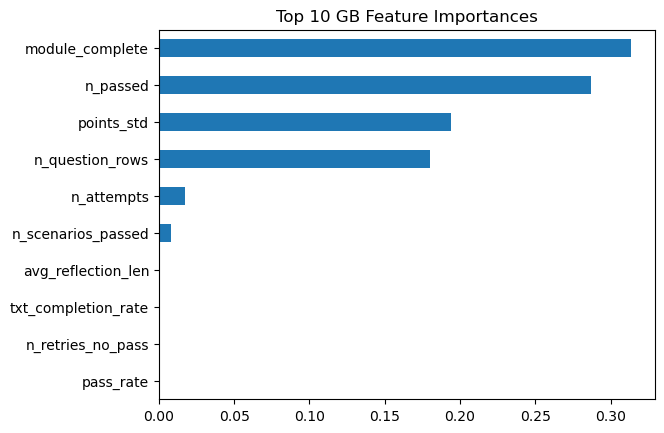

In [46]:
gb.fit(X, y)                       # full-data fit
importances = (pd.Series(gb.feature_importances_, index=X.columns)
                 .sort_values(ascending=False))

print("Top 10 features driving GB model:")
display(importances.head(10))

# optional: plot
import matplotlib.pyplot as plt
importances.head(10).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 10 GB Feature Importances")
plt.show()


# Verdict
| Aspect | What you saw | What it means |
|--------|--------------|---------------|
| **Single 75 / 25 split** | Logistic ≈ 92 % accuracy, GB = 100 % | Test set is only **12 learners**; one flip changes accuracy by 8 %. |
| **5-fold CV** | Logistic F1 ≈ 0.98, GB F1 = 1.00 every fold | Cross-validation confirms the model almost never mis-labels in *any* fold—still a red flag for over-fit or label leakage. |
| **Feature importances (GB)** | Top weights: `n_attempts, points_std, n_question_rows, n_scenarios_passed` | Model focuses on *volume* and *spread of scores*—intuitively sensible. Quick-wins like `pass_rate` carry zero weight, suggesting they’re redundant with the top four. |


- perfect scores are too good to be true -> Tiny dataset

- Potential label leakage
Recent-7-day features overlap fall_behind rules
Even though we excluded days_since_last, the model learn a near-proxy (recent_7d_attempts = 0 ➜ very likely behind)


# Suggested next steps

| Step | Why |
|------|-----|
| **1. Remove obvious proxies for the label** | Forces the model to use deeper signals (gap cadence, reflection behaviour). |
| **2. Robust time-based validation** | Train on learners who finished *before* Oct-2024; test on the last cohort. Mimics real deployment and breaks any temporal leakage. |
| **3. Simpler model as sanity check** | Using a `DummyClassifier` to confirm the lift you get from real features. |
| **4. Calibration & threshold tuning** | Coaches may want high-recall -> a threshold > 0.5. |
| **6. Collect more labelled data** | Combine two or three cohorts if possible to give more reliable CV variance. |